In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from pylab import rcParams
import calendar

In [2]:
# Read data
df = pd.read_csv('train_1.csv/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
df = df.fillna(0)

In [4]:
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [ ]:
df_reshaped['Date'] = pd.to_datetime(df_reshaped['Date']) 
df_reshaped = df_reshaped.set_index('Date')

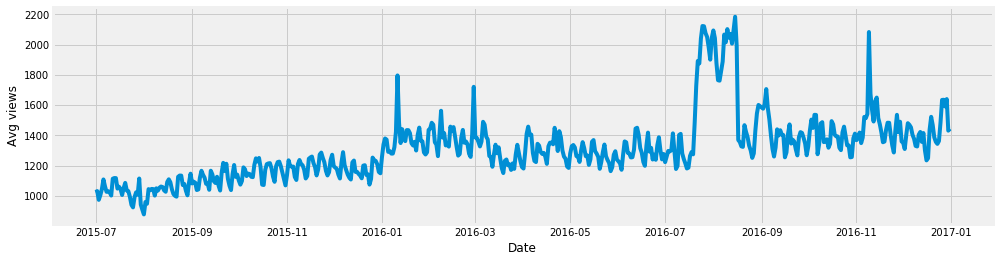

In [ ]:
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.plot(temp)

In [ ]:
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index).mean()
months=['January','Feb','March','April','May','June','July','August','September','October','November','December']

ax = views_by_month.plot()
start, end = ax.get_xlim()
plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
ax.set_xticklabels(months,rotation=75)
ax.set_xlabel('Month')
ax.set_ylabel('Average views')
plt.show()

In [ ]:
weekday_index = df_reshaped.index.weekday_name
views_by_weekdays = df_reshaped.groupby(weekday_index).sum()
#months=['January','Feb','March','April','May','June','July','August','September','October','November','December']

ax = views_by_weekdays.plot()
#start, end = ax.get_xlim()
#plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
#ax.set_xticklabels(months,rotation=75)
#ax.set_xlabel('Month')
ax.set_ylabel('Total views')
plt.show()

In [ ]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'
    
df_reshaped['Page_language'] = df_reshaped.Page.apply(detect_lang)

def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'
    
df_reshaped['Page_language'] = df_reshaped.Page_language.apply(lang_code)

In [ ]:
fig,ax = plt.subplots(figsize=(15,6))
lang_df = df_reshaped.groupby('Page_language')['Views'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Views'] = round(lang_df['Views']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height()+500))
ax.legend()
plt.show()

In [ ]:
df_reshaped['Dayofweek'] = df_reshaped.Date.dt.dayofweek

def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'
    
df_reshaped['Dayofweek'] = df_reshaped.Dayofweek.apply(find_day)

In [ ]:
day = df_reshaped.groupby('Dayofweek')['Views'].sum()
plt.figure(figsize=(15,4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day)
plt.show()

In [ ]:
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages.nlargest(5,'Views')

In [ ]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(['Main_Page_en.wikipedia.org_all-access_all-agents','Main_Page_en.wikipedia.org_desktop_all-agents','Main_Page_en.wikipedia.org_mobile-web_all-agents','Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents','Special:Search_en.wikipedia.org_all-access_all-agents'])]

In [ ]:
for i in list(top5_pages_df.Page.unique())[:5]:
    ax = top5_pages_df.loc[top5_pages_df.Page == i,:].Views.plot(label=i)
ax.set_ylabel('Views')
plt.legend(loc='upper left')
plt.show()

In [ ]:
table = pd.pivot_table(top5_pages_df,values='Views',index=['Date'],columns=['Page'])

In [ ]:
corr_matrix = table.corr(method='pearson')
sns.clustermap(corr_matrix)

In [ ]:
top_page_df = df_reshaped[df_reshaped.Page == 'Main_Page_en.wikipedia.org_all-access_all-agents']
top_page_df.head()

In [ ]:
ax1 = top_page_df.boxplot()

In [ ]:
ax2 = top_page_df.plot(kind='density', linewidth=2)
ax2.set_xlabel('Views')
plt.show()

In [ ]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

In [ ]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df['Views'],freq = 30)
figure = ts_decomposition.plot()
plt.show()

## Augmented Dicky-Fuller test

In [ ]:
test = adfuller(top_page_df['Views'])
print(test)

 0th element is the test statistic. Since the value is approximately -3, we can say that the data is more likely to be stationary.
 1st element indicates the p-value. Since the p-value is < 0.05, we can reject null hypothesis.

In [ ]:
ax = top_page_df.plot()
plt.show()

In [ ]:
top_page_filtered = top_page_df[['Views']]
stationary_df = top_page_filtered.diff().dropna()
stationary_df.head()

In [ ]:
ax = stationary_df.plot()
plt.show()

In [ ]:
test2 = adfuller(stationary_df['Views'])
print(test2)

In [ ]:
fig = tsaplots.plot_acf(stationary_df['Views'], lags=14)
plt.show()